In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from skimage import io
from dataloader import CellDataset
from torch.utils.data import DataLoader
from modules import *
from networks import UNet
from functions import *
from utils import *
import os
from ssim import ssim
from instruments import model_load, edgetaper

## Load image

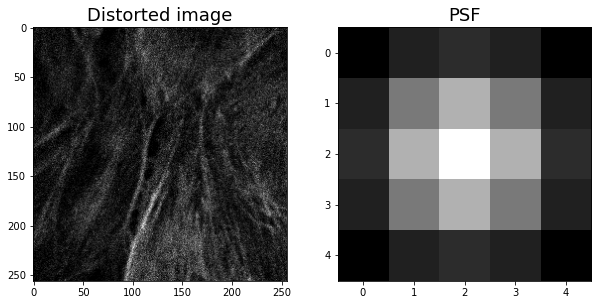

In [3]:
image = io.imread('./images/demo_poisson1.tif')
psf = io.imread('./images/demo_psf_poisson1.tif')
gt = io.imread('./images/demo_gt_poisson1.tif')

#Create tensors
image = torch.Tensor(image[None, None])
psf = torch.Tensor(psf[None, None])
gt = torch.Tensor(gt[None, None])

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(image[0][0], cmap='gray')
ax[0].set_title('Distorted image', fontsize=18)

ax[1].imshow(psf[0][0], cmap='gray')
ax[1].set_title('PSF', fontsize=18)

#Apply Anscombe transform
image = anscombe(image)
# Edgetapering operation to avoid boundary artifacts
image = edgetaper(image, psf)

## Load model

In [3]:
model_path = './models/'

#Select method
method='WFK' #from 'WFK', 'WF_KPN', 'WF_KPN_SA', 'WF_UNet'

model = model_load('poisson', method, model_path)

## Apply model 

In [4]:
if (method == 'WFK') or (method=='WF_KPN'):
    out = model((image, psf))
elif method == 'WF_UNet':
    out = model(image, psf, 10)
elif method == 'WF_KPN_SA':
    out = model(image, psf)

#Crop output to the original shape after the edgetaper(input)
out = crop_psf_shape(out, psf)
out = out / gt.max()
gt_copy = gt / gt.max()

Text(0.5, 1.0, 'Ground truth image')

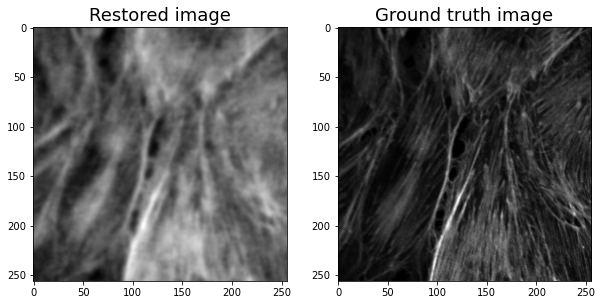

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(out[0][0].detach().cpu().numpy(), cmap='gray')
ax[0].set_title('Restored image', fontsize=18)
ax[1].imshow(gt[0][0].detach().cpu().numpy(), cmap='gray')
ax[1].set_title('Ground truth image', fontsize=18)

In [6]:
psnr = calc_psnr(out.clamp(0,1), gt_copy.clamp(0,1))
s_sim = ssim(out.clamp(0,1), gt_copy.clamp(0,1))
print('Restored PSNR %.2f, SSIM %.4f'% (psnr, s_sim))

Restored PSNR 22.33, SSIM 0.5212
